In [16]:
import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))
sys.path.append(str(Path("../..").resolve()))

from src.data_ingestion import *
from src.data_preprocessing import *
from src.descriptive_analytics import *

from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql.types import NumericType, StringType
from pyspark.sql import functions as F

import seaborn as sns

import numpy as np

from itertools import combinations

from scipy import stats

import matplotlib.pyplot as plt

import pandas as pd



In [17]:
spark = init_spark()
df = load_data(spark, "../../data/US_Accidents_March23.csv")

In [18]:
# missing_values = check_missing_values(df)

## Cleaning Data

In [19]:
# df = cast_columns(df)
# df = drop_high_missing_columns(df)
# df = impute_missing_values(df)
# df.cache()

In [20]:
# df.describe().show()

In [21]:
# missing_values = check_missing_values(df)

### Road Analysis

In [ ]:
from pyspark.sql.functions import sum as spark_sum, col, count, when, lit
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# List of road features to analyze (boolean columns)
road_features = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
    'Traffic_Signal', 'Turning_Loop'
]

df.select(road_features).sample(False, 0.01)


# 2. Correct Approach: Count True values for each boolean feature
print("\n=== Counting accidents by road feature ===")
# Convert boolean to 1/0 then sum
feature_counts = df.agg(*[
    spark_sum(when(col(feature) == True, 1).otherwise(0)).alias(feature) 
    for feature in road_features
]).toPandas()

feature_counts_series = feature_counts.transpose()[0].sort_values(ascending=False)
feature_counts_series.name = "Accident Count"

# 3. Enhanced Visualizations
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=feature_counts_series.index, 
                 y=feature_counts_series.values,
                 palette="viridis")

# Add value labels
for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):,}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.title('Accidents Associated with Road Features', pad=20)
plt.ylabel('Number of Accidents')
plt.xlabel('Road Features')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()
plt.tight_layout()
plt.savefig('road_feature_accidents.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Percentage Analysis
total_accidents = df.count()
percentage_impact = (feature_counts_series / total_accidents * 100).round(2)

print("\nPercentage of accidents associated with each feature:")
print(percentage_impact.sort_values(ascending=False))



=== Counting accidents by road feature ===


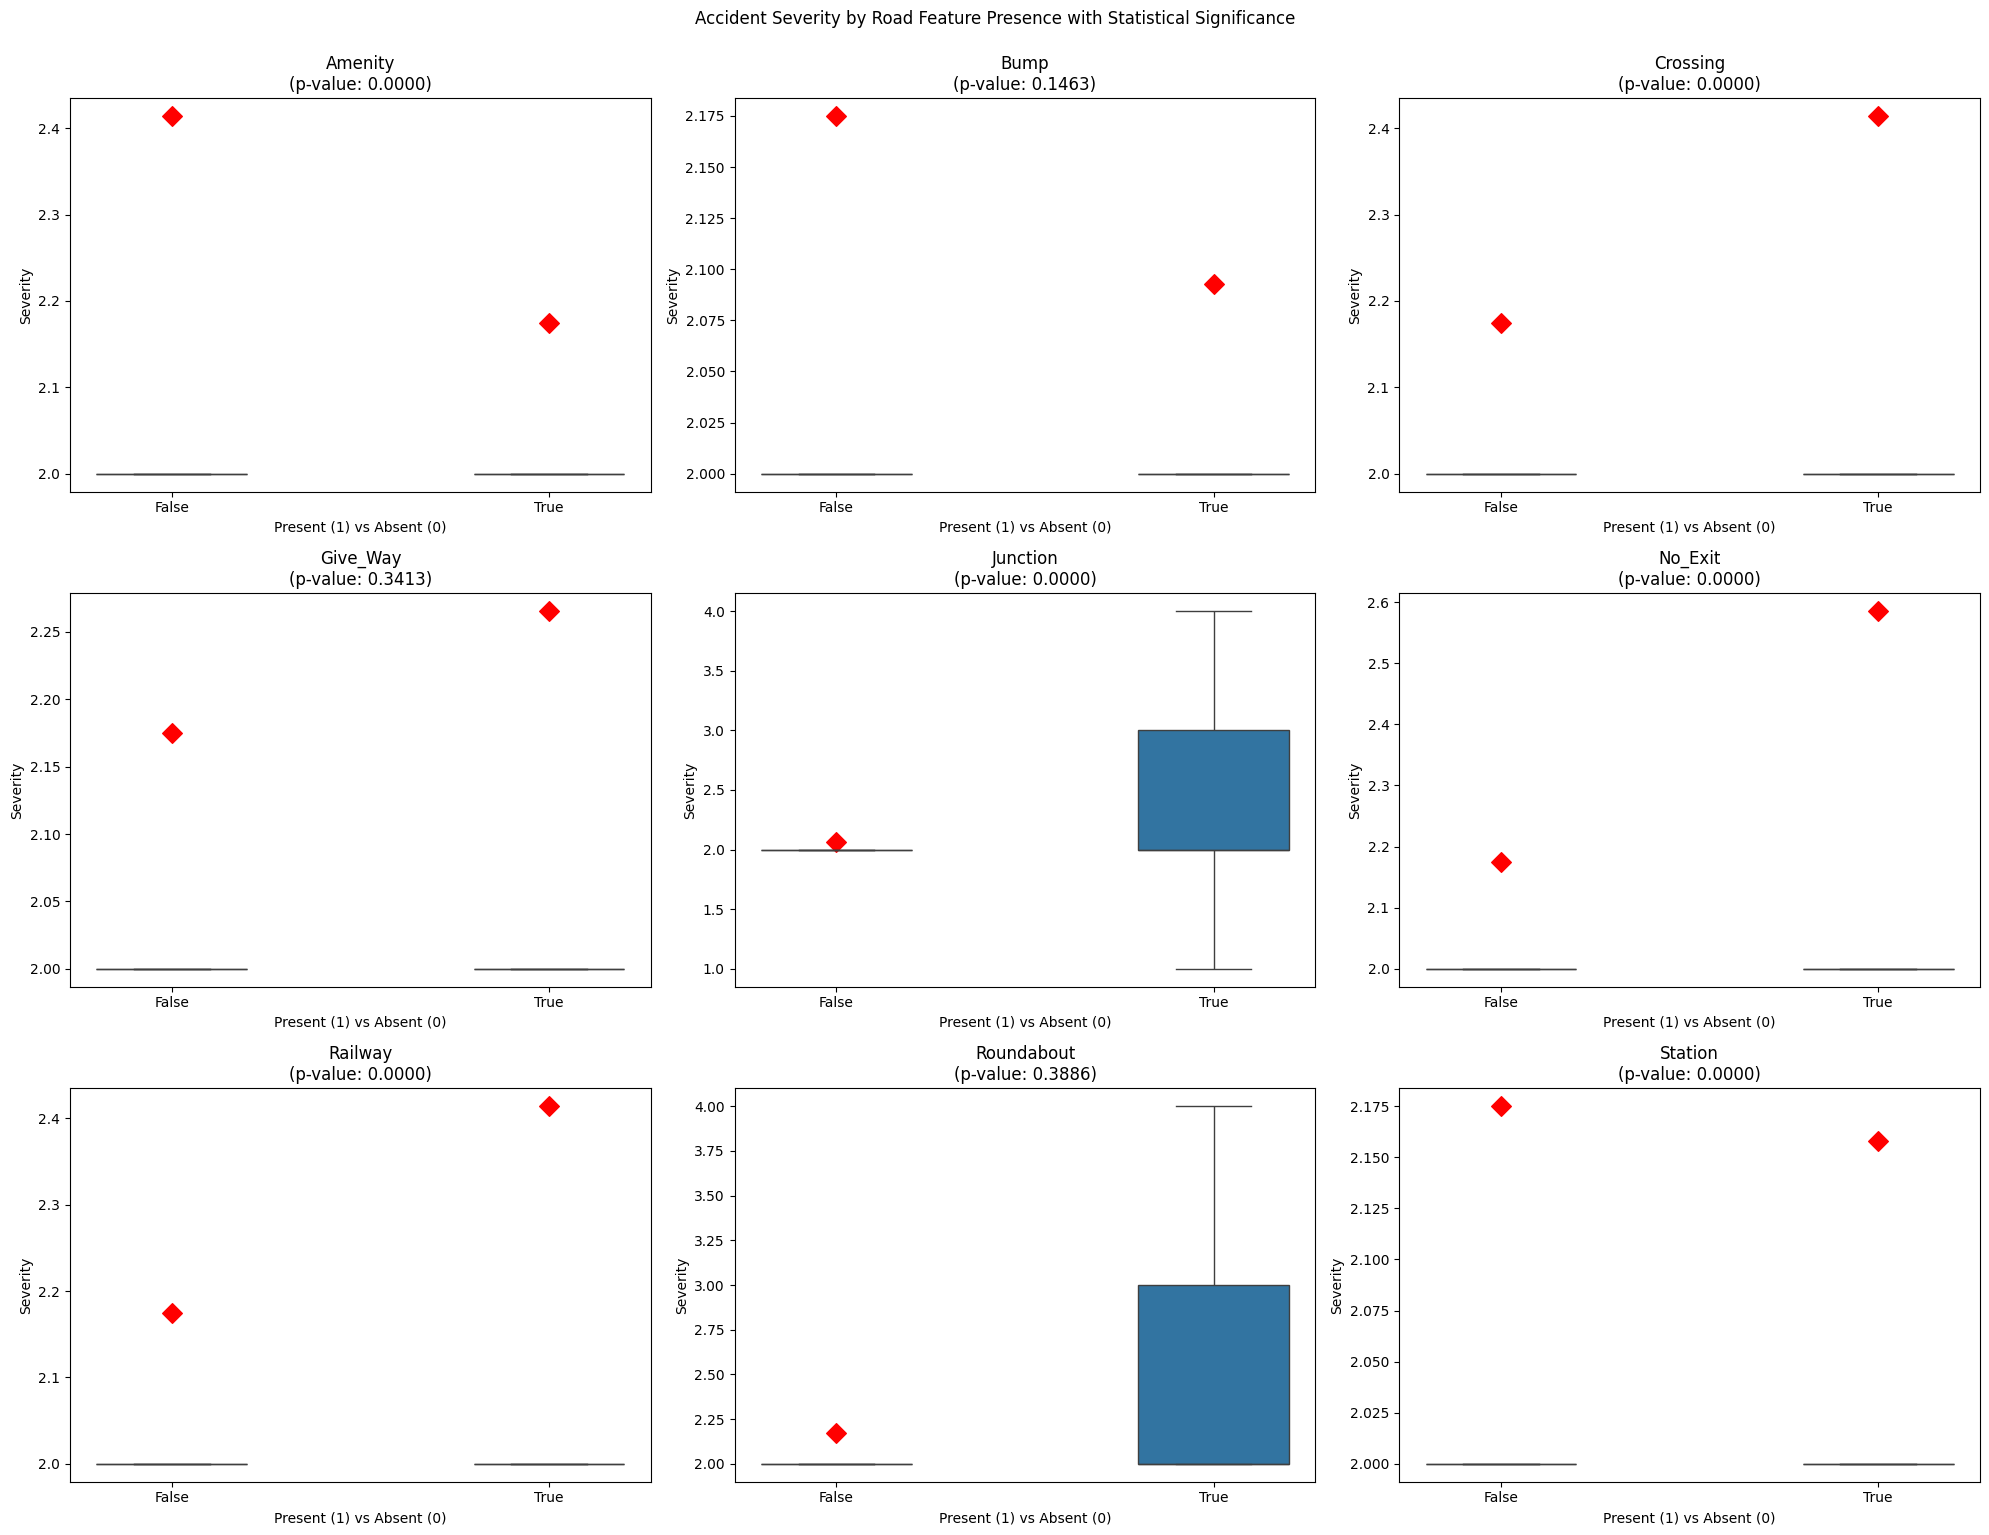

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import functions as F
from scipy import stats

# 1. Sample Data Efficiently
# Reduce fraction further or use a smaller subset of features
sample_fraction = 0.01  # Adjust based on dataset size
sample_df = df.select(road_features[:9] + ['Severity']).sample(fraction=sample_fraction).toPandas()

# 2. Precompute Statistics in Spark
# Aggregate mean and count for each feature in Spark to avoid iterative calculations
stats_by_feature = (
    df.groupBy(*road_features[:9])
    .agg(F.mean('Severity').alias('mean_severity'), F.count('*').alias('count'))
    .toPandas()
)

# Melt the aggregated statistics for easier plotting
melted_stats = stats_by_feature.melt(id_vars=['mean_severity'], value_vars=road_features[:9],
                                     var_name='Feature', value_name='Presence')

# 3. Plot Enhanced Box Plots with Statistical Significance
plt.figure(figsize=(20, 15))
for i, feature in enumerate(road_features[:9]):
    plt.subplot(3, 3, i + 1)
    
    # Filter for binary values only (already binary, so this is a safeguard)
    plot_data = sample_df[sample_df[feature].isin([0, 1])]
    
    # Create boxplot
    sns.boxplot(x=feature, y='Severity', data=plot_data, width=0.4, showfliers=False)
    
    # Add mean markers (precomputed in Spark)
    group0_mean = melted_stats[(melted_stats['Feature'] == feature) & (melted_stats['Presence'] == 0)]['mean_severity'].values[0]
    group1_mean = melted_stats[(melted_stats['Feature'] == feature) & (melted_stats['Presence'] == 1)]['mean_severity'].values[0]
    plt.scatter(0, group0_mean, color='red', s=100, marker='D', label='Mean')
    plt.scatter(1, group1_mean, color='red', s=100, marker='D')
    
    # Add p-value annotation (calculated in Spark)
    group0 = plot_data[plot_data[feature] == 0]['Severity']
    group1 = plot_data[plot_data[feature] == 1]['Severity']
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
    plt.title(f'{feature}\n(p-value: {p_val:.4f})')
    plt.xlabel('Present (1) vs Absent (0)')
    plt.ylabel('Severity')

plt.tight_layout()
plt.suptitle('Accident Severity by Road Feature Presence with Statistical Significance', y=1.02)
plt.show()

C:\Users\Ahmed Osama\AppData\Local\Temp\ipykernel_3132\816776886.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='feature', y='mean_severity', hue='Presence',
C:\Users\Ahmed Osama\AppData\Local\Temp\ipykernel_3132\816776886.py:14: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(x='feature', y='mean_severity', hue='Presence',


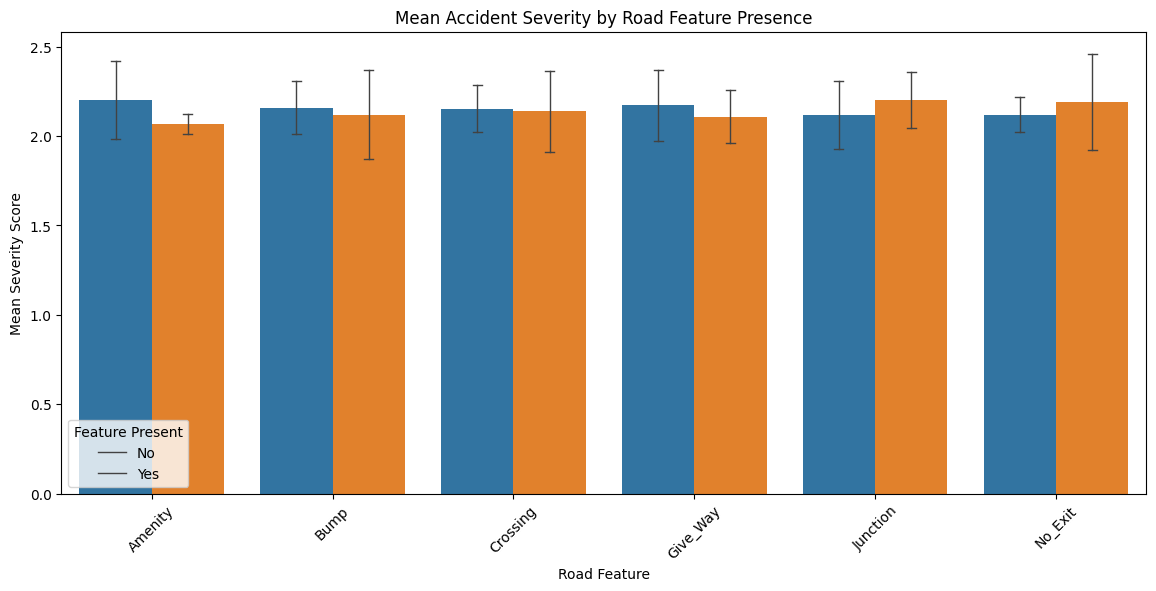

In [ ]:
# Aggregate mean severity for each feature in one pass
mean_severities = (
    df.groupBy(*road_features[:6])
    .agg(F.mean('Severity').alias('mean_severity'), F.count('*').alias('count'))
    .toPandas()
)

# Melt the DataFrame for plotting
mean_results = mean_severities.melt(id_vars=['mean_severity'], value_vars=road_features[:6], 
                                    var_name='feature', value_name='Presence')

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x='feature', y='mean_severity', hue='Presence', 
            data=mean_results[mean_results['Presence'].isin([0, 1])],
            ci='sd', errwidth=1, capsize=0.1)
plt.xticks(rotation=45)
plt.title('Mean Accident Severity by Road Feature Presence')
plt.ylabel('Mean Severity Score')
plt.xlabel('Road Feature')
plt.legend(title='Feature Present', labels=['No', 'Yes'])
plt.show()

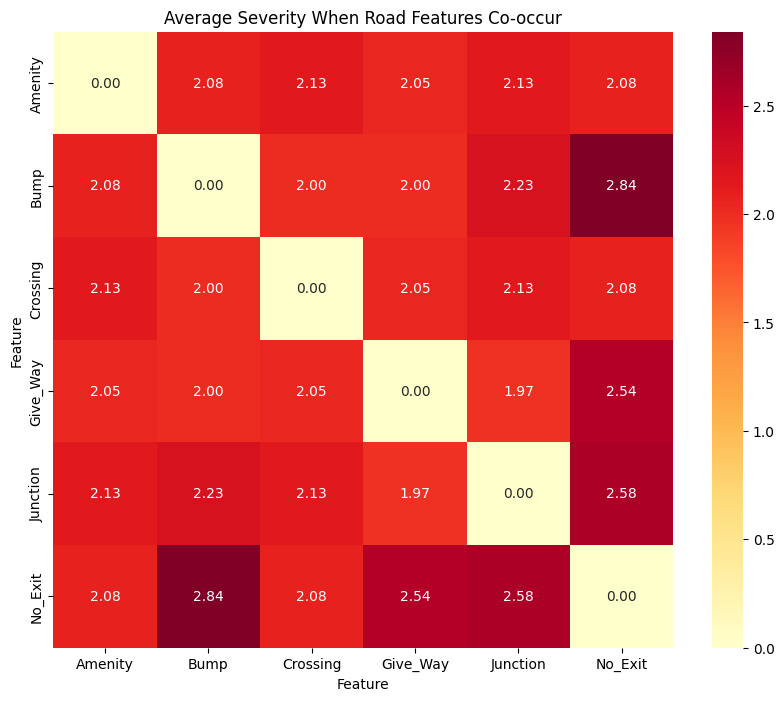

In [ ]:

# Define top features
top_features = road_features[:6]

# Generate all unique pairs of features
feature_pairs = list(combinations(top_features, 2))

# Compute co-occurrence averages in one pass using Spark SQL
co_occurrence_data = (
    df.select(*top_features, 'Severity')
    .groupBy(*top_features)
    .agg(F.mean('Severity').alias('avg_severity'))
    .toPandas()
)

# Initialize co-occurrence matrix
co_occurrence_matrix = np.zeros((len(top_features), len(top_features)))

# Populate the matrix with average severities
for f1, f2 in feature_pairs:
    # Filter rows where both features are present (1)
    avg_severity = co_occurrence_data[
        (co_occurrence_data[f1] == 1) & (co_occurrence_data[f2] == 1)
    ]['avg_severity'].values
    avg_severity = avg_severity[0] if len(avg_severity) > 0 else 0  # Handle nulls
    
    # Update the matrix symmetrically
    i, j = top_features.index(f1), top_features.index(f2)
    co_occurrence_matrix[i, j] = avg_severity
    co_occurrence_matrix[j, i] = avg_severity

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, fmt=".2f",
            xticklabels=top_features,
            yticklabels=top_features,
            cmap="YlOrRd", vmin=co_occurrence_matrix.min(), vmax=co_occurrence_matrix.max())
plt.title('Average Severity When Road Features Co-occur')
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.show()

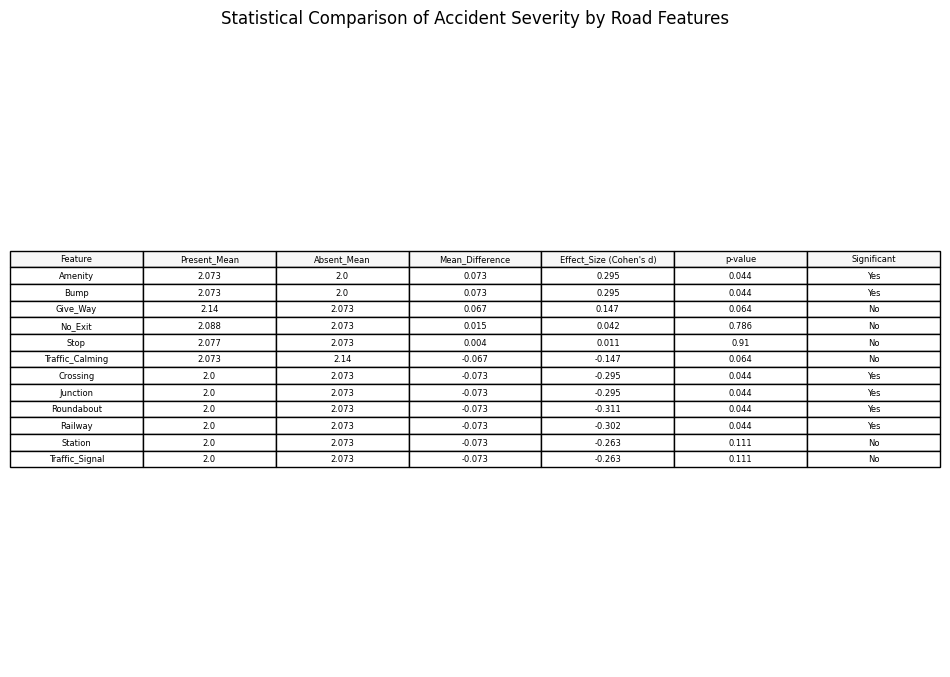

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from scipy import stats

# Define road features
road_features = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
    'Traffic_Signal', 'Turning_Loop'
]

# Aggregate statistics in Spark for all features in one pass
feature_stats = (
    df.select(*road_features, "Severity")
    .groupBy(*road_features)
    .agg(
        F.mean("Severity").alias("mean_severity"),
        F.stddev("Severity").alias("std_severity"),
        F.count("*").alias("count")
    )
    .toPandas()
)

# Reshape the aggregated statistics for easier processing
results = []
for feature in road_features:
    # Extract statistics for present (1) and absent (0)
    present_stats = feature_stats[feature_stats[feature] == 1]
    absent_stats = feature_stats[feature_stats[feature] == 0]
    
    # Skip if no data for either group
    if present_stats.empty or absent_stats.empty:
        continue
    
    present_mean = present_stats["mean_severity"].values[0]
    absent_mean = absent_stats["mean_severity"].values[0]
    present_std = present_stats["std_severity"].values[0]
    absent_std = absent_stats["std_severity"].values[0]
    present_count = present_stats["count"].values[0]
    absent_count = absent_stats["count"].values[0]
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind_from_stats(
        mean1=present_mean, std1=present_std, nobs1=present_count,
        mean2=absent_mean, std2=absent_std, nobs2=absent_count,
        equal_var=False
    )
    
    # Calculate mean difference and effect size (Cohen's d)
    mean_diff = present_mean - absent_mean
    pooled_std = np.sqrt(((present_std**2 * (present_count - 1)) + (absent_std**2 * (absent_count - 1))) / (present_count + absent_count - 2))
    cohen_d = mean_diff / pooled_std if pooled_std > 0 else 0
    
    # Append results
    results.append({
        'Feature': feature,
        'Present_Mean': present_mean,
        'Absent_Mean': absent_mean,
        'Mean_Difference': mean_diff,
        'Effect_Size (Cohen\'s d)': cohen_d,
        'p-value': p_val,
        'Significant': 'Yes' if p_val < 0.05 else 'No'
    })

# Convert results to a DataFrame and sort by mean difference
results_df = pd.DataFrame(results).sort_values('Mean_Difference', ascending=False)

# Display formatted table
plt.figure(figsize=(12, 8))
plt.axis('off')
plt.table(cellText=results_df.round(3).values,
          colLabels=results_df.columns,
          cellLoc='center',
          loc='center',
          colColours=['#f7f7f7'] * len(results_df.columns))
plt.title('Statistical Comparison of Accident Severity by Road Features', pad=20)
plt.show()

### **Key Insights Summary (Bullet Points)**

- **High-Risk Feature Combinations**:
  - Combinations like `No_Exit` + `Bump` and `Junction` + `No_Exit` lead to higher accident severity.

- **Features That Reduce Severity**:
  - Features like `Crossing`, `Junction`, `Railway`, and `Roundabout` reduce severity when present.
  - These features likely improve traffic flow, visibility, or driver awareness.

- **Features With Minimal Impact**:
  - Features such as `Give_Way`, `No_Exit`, `Stop`, `Station`, and `Traffic_Signal` have little to no significant effect on severity.

- **Statistically Significant Features**:
  - `Amenity`, `Bump`, `Crossing`, `Junction`, `Railway`, and `Roundabout` show statistically significant impacts on severity.
--- 